# Libraries

#### Data exploration and visualization

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm as tqdm

#### Raster manipulation

In [2]:
import rasterio as rio
from rasterio import warp, mask, features
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image, adjust_band, reshape_as_raster

#### Manipulate polygons.

In [3]:
from pyproj import Proj, Transformer, transform
#from shapely.geometry import Polygon

#### Geospatial data processing

In [4]:
from glob import glob
from osgeo import gdal, ogr, osr

In [5]:
import sys
sys.path.append('D:\Programación\soil_desertification\src')
from utils.utilities import *

# Raster exploration

#### Label paths and rasters

In [6]:
raster_path = '../data/images/processed/products/L8/LC08_L1TP_010063_20150713_20200908_02.tif'

#### Label image processing

##### Preprocessing of the study mosaic

In [7]:
dataset_raster = open_raster(raster_path)

Numero de bandas en la imagen: 8

Tamaño de la imagen es: 7751 filas x 7611 columnas

Raster driver: GTiff

Proyeccion de Imagen:
PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [8]:
dataset = read_raster(dataset_raster)
dataset.shape

(8, 7751, 7611)

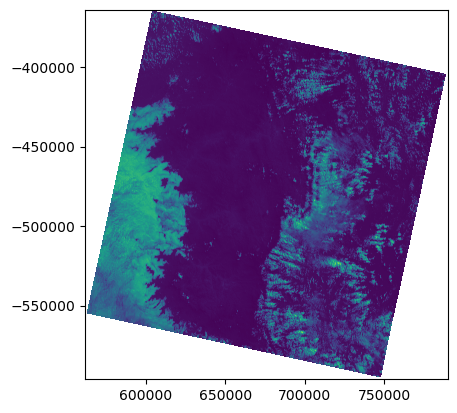

<Axes: >

In [9]:
show(dataset_raster)

##### Let's calculate the NDVI

In [10]:
bandNIR = dataset[4, :, :]
bandRed = dataset[3, :, :]

ndvi = np.clip((bandNIR.astype(float) - bandRed.astype(float)) /
               (bandNIR.astype(float) + bandRed.astype(float)), -1, 1)

print('\nMax NDVI: {m:.2f}'.format(m=ndvi.max()))
print('Mean NDVI: {m:.2f}'.format(m=ndvi.mean()))
print('Median NDVI: {m:.2f}'.format(m=np.median(ndvi)))
print('Min NDVI: {m:.2f}'.format(m=ndvi.min()))

C:\Users\12758\AppData\Local\Temp\ipykernel_9424\1501541127.py:4: RuntimeWarning: invalid value encountered in divide
  ndvi = np.clip((bandNIR.astype(float) - bandRed.astype(float)) /



Max NDVI: nan
Mean NDVI: nan
Median NDVI: nan
Min NDVI: nan


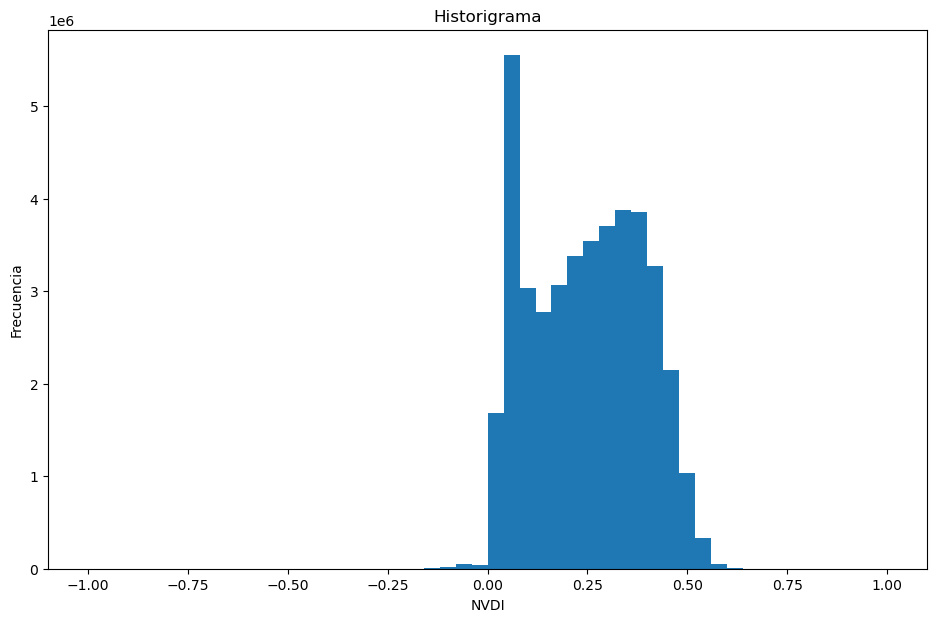

In [11]:
figure, axs = plt.subplots(figsize=(1.62*7, 7))
axs.hist(ndvi.flatten(), bins=50)
plt.title("Historigrama")
plt.xlabel("NVDI")
plt.ylabel("Frecuencia")
plt.show()

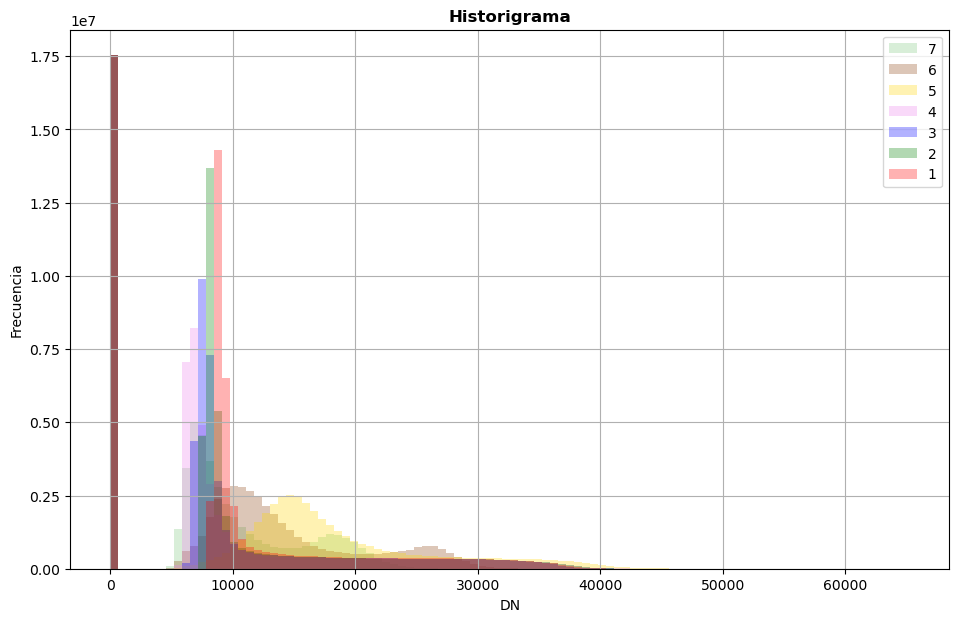

In [12]:
figure, axs = plt.subplots(figsize=(1.62*7, 7))

rio.plot.show_hist(dataset_raster.read([1, 2, 3, 4, 5, 6, 7]),
                        bins=100,
                        histtype='stepfilled',
                        lw=0.0,
                        stacked=False,
                        alpha=0.3,
                        ax=axs,
                        title="Historigrama",
                        label=[1, 2, 3, 4, 5, 6, 7]
                        )
axs.set_xlabel('DN')
_ = axs.set_ylabel('Frecuencia')

##### Display the image and the NDVI side by side

(3, 7751, 7611)
(7751, 7611, 3)


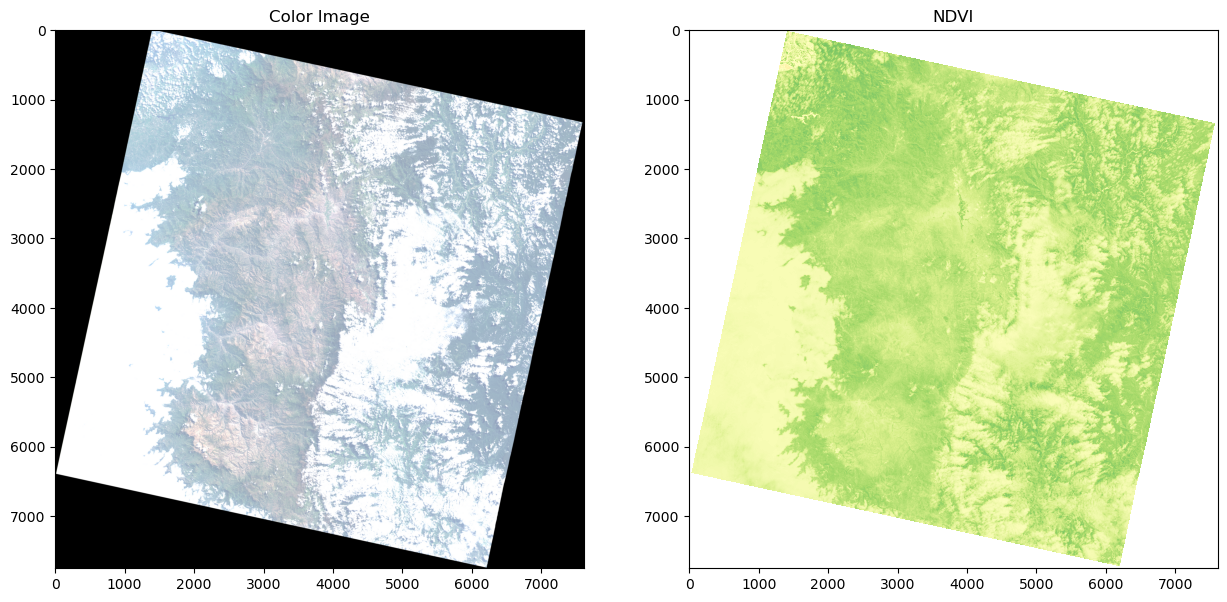

In [13]:
# extraer las bandas que queremos visualizar
index = np.array([3, 2, 1])
colors = dataset[index, :, :].astype(np.float64)

# usaremos los valores para estirar la imagen landsat basándonos en el histograma anterior
max_val = 10000
min_val = 0

# imponer valores máximos y mínimos
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# los raster tienen el formato [bandas, filas, cols] mientras que las imágenes son típicamente [filas, cols, bandas]
# por lo que hay que cambiar la forma de nuestra matriz
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 15)) 

# Mostrar la imagen en color
axs[0].imshow(colors_reshaped)
axs[0].set_title('Color Image')

# Mostrar NDVI
axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title('NDVI')

plt.show()

##### Let's check the quality band

0b1
0b101010100000010
0b101010101000000
0b101010110000010
0b101010111000000
0b101011000000010
0b101011001000000
0b101011010000010
0b101011011000000
0b101011100001000
0b101110100010010
0b101110101010000
0b101111000010010
0b101111001010000
0b111010100100010
0b1101010100000110
0b1101010101000100
0b1101011000000110
0b1101011001000100
0b1101011100001100


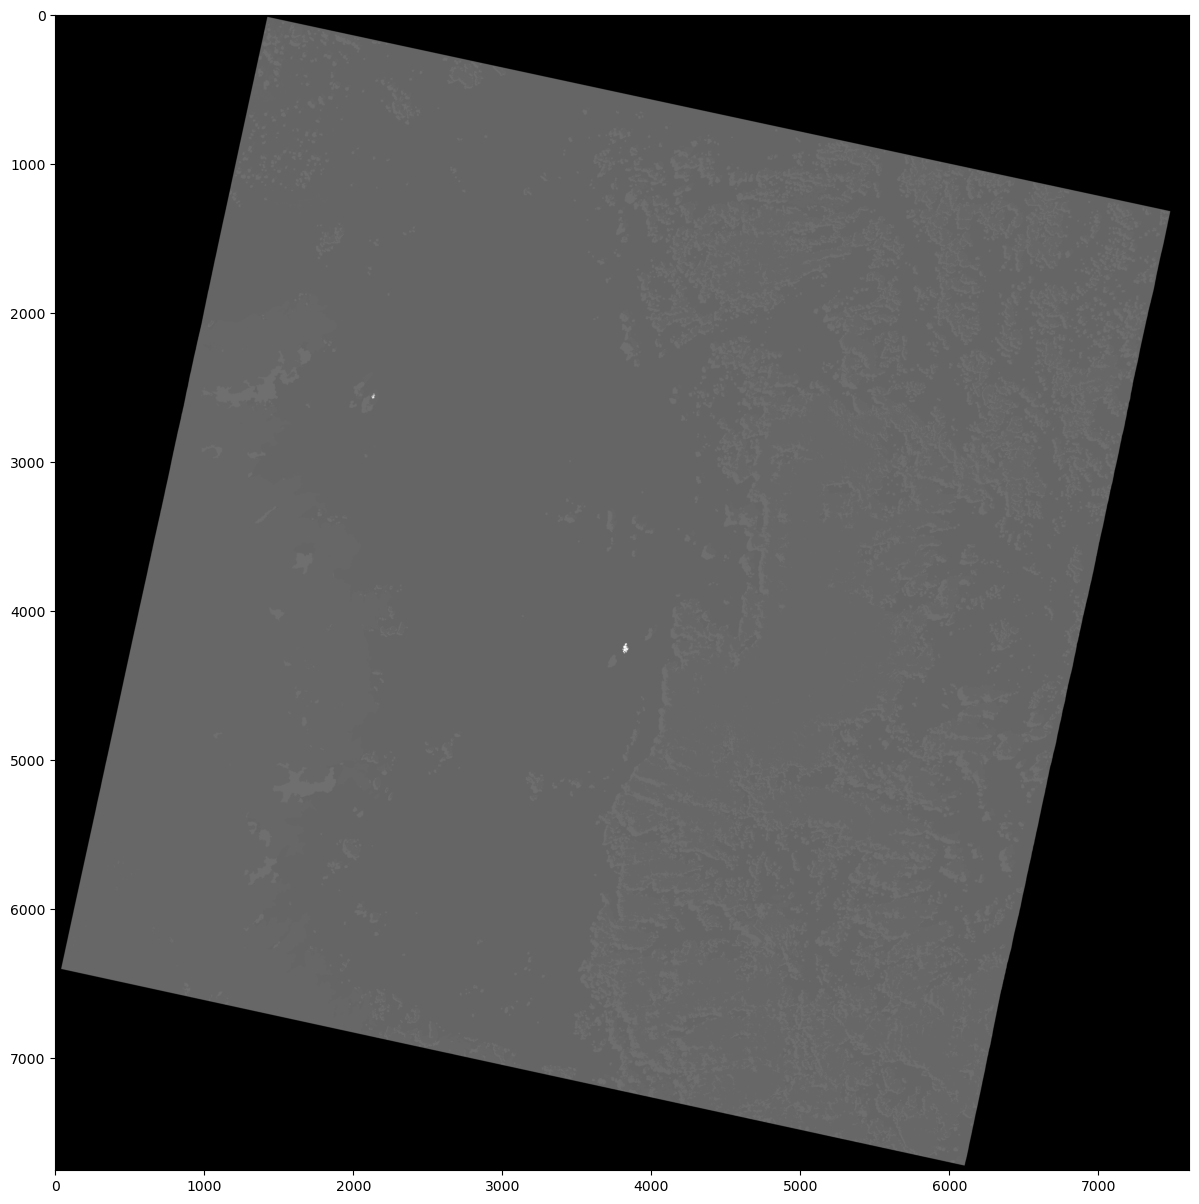

In [14]:
qa_band = dataset[7, :, :]
qa_band[qa_band == -9999] = 0

for i in np.unique(qa_band):
    print(bin(i))

fig, ax = plt.subplots(figsize=(15, 15))
_ = ax.imshow(qa_band, cmap='gray')

##### Take out bit flag for water and view

In [15]:
water_bits = []

for i in qa_band.flatten():
    if bin(i) == '0b0' or bin(i) == '0b1':
        water_bits.append(0)
    else:
        water_bits.append(int(bin(i)[8]))

In [16]:
water_bits_raster = np.array(water_bits).reshape(dataset[0].shape)

ValueError: cannot reshape array of size 58992861 into shape (8,7751,7611)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(water_bits_raster, cmap='gray', interpolation='None')